## Project Setup
This section largely follows the example notebook that was kindly provided by Alicia Williams [here](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/bigquery_generative_ai_intro.ipynb).

In [1]:
PROJECT_ID = "kaggle-clinical-trials"
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!bq mk --connection --location=us \
    --connection_type=CLOUD_RESOURCE kaggle_connection

BigQuery error in mk operation: Already Exists: Connection
projects/343445875157/locations/us/connections/kaggle_connection


In [4]:
SERVICE_ACCT = !bq show --format=prettyjson --connection us.kaggle_connection | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]
print(SERVICE_ACCT_EMAIL)

bqcx-343445875157-6h15@gcp-sa-bigquery-condel.iam.gserviceaccount.com


In [5]:
import time

!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role='roles/bigquery.connectionUser'
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role='roles/aiplatform.user'
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role='roles/storage.objectViewer'

# wait 60 seconds, give IAM updates time to propagate, otherwise, following cells will fail
time.sleep(60)

Updated IAM policy for project [kaggle-clinical-trials].
Updated IAM policy for project [kaggle-clinical-trials].
Updated IAM policy for project [kaggle-clinical-trials].


# Closing the Accrual Gap in Cancer Clinical Trials

Clinical trials are carefully run studies that test whether new cancer treatments are safe and actually help patients. For a trial to work, enough patients have to enroll. In oncology, very few people do: only about 4% of eligible adults with cancer enroll. Roughly 40% of cancer clinical trials end up short of the number of participants they planned for, and a surprisingly high number (over 20%) never enroll anyone at all.

When enrollment lags, trials become underpowered, leaving primary questions unanswered and results difficult or impossible to interpret. That means months or years of work, money, and patient effort may not lead to clear answers.  It also slows the arrival of better treatments, makes research more expensive, and leaves patients and doctors with fewer good options to consider.

My work addresses the challenge of patient enrollment with two tightly linked projects on a shared BigQuery AI backbone. In Project 1, I predict the risk a trial will have low-accrual before launch by structuring messy, free-text data and engineering feasibility signals. Sponsors of trials can use the results of such a prediction model to help design trials that are more likely to achieve their target enrollment, and target limited resources to proactively support accrual efforts on some inevitably high risk trials. In Project 2, I make it easier for patients and clinicians to actually find relevant studies by encoding eligibility text and patient's profiles as embeddings, so a plain-language description (e.g., “Stage IV melanoma after anti-PD1 treatment”) retrieves clinically compatible trials. Together, these projects aim to support getting more patients on to the right trials by making trials more likely to hit enrollment targets and easier to find.

## Primary Dataset: Aggregate Analysis of Clinical Trials (AACT) database

Both of the projects described here will leverage the Aggregate Analysis of Clinical Trials (AACT). The AACT is a publicly available relational database that contains detailed (but messy!) information about every study registered in ClinicalTrials.gov. Content is downloaded from ClinicalTrials.gov daily and loaded into AACT. Other can obtain their own user name and password to access this database (for free!) by registering at [here](https://aact.ctti-clinicaltrials.org/).



In [7]:
import pandas as pd
from sqlalchemy import create_engine, text
from google.colab import userdata

USER = "kaggleuser"
PASSWORD = "kaggle-clinical-trials" # don't worry, this isn't really secret :)
HOST = "aact-db.ctti-clinicaltrials.org"
PORT = "5432"
DB = "aact"

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")


### Filtering to industry-sponsored, cancer clinical trials
The AACT (Aggregate Analysis of ClinicalTrials.gov) database contains records from several million clinical studies registered worldwide. By U.S. law, pharmaceutical and biotechnology companies that launch trials in the United States must register these studies on ClinicalTrials.gov.

These analyses are limited to industry-sponsored Phase 2 and Phase 3 cancer clinical trials with at least one U.S. site, largely to keep the scope of the project reasonable as a prototype; however, the methods and approach could easily be extended to other types of trials or conditions. Industry-sponsored Phase 2 and Phase 3 studies are the most relevant for understanding the development of new cancer treatments. They represent the critical stage of drug development and are designed to evaluate whether an investigational therapy shows meaningful signs of benefit (Phase 2) and then to rigorously confirm efficacy and safety in larger, definitive populations (Phase 3) to support FDA approval.

This sample of trials is not only the foundation for regulatory approval decisions in the US, but also the key opportunities for patients to gain access to promising, new therapies before they are commercially available. That said, many early and late phase studies as well as academic-led projects play important roles in discovery and advancing clinical practice.

In [31]:
query = """
WITH us_sites AS (
  SELECT DISTINCT nct_id
  FROM facilities
  WHERE country = 'United States'
), cancer_studies AS (
  SELECT DISTINCT nct_id,
    COALESCE(
    ARRAY_AGG(DISTINCT downcase_mesh_term)
      FILTER (WHERE downcase_mesh_term IS NOT NULL),
    ARRAY[]::text[]
  ) AS mesh_conditions
  FROM browse_conditions
  --we'll be broad here and then properly filter to truly cancer-related trials with Gemini below
  WHERE downcase_mesh_term ILIKE '%cancer%' OR
        downcase_mesh_term ILIKE '%neoplasm%' OR
        downcase_mesh_term ILIKE '%malignant%' OR
        downcase_mesh_term ILIKE '%mesothelioma%' OR
        downcase_mesh_term ILIKE '%melanoma%' OR
        downcase_mesh_term ILIKE '%carcinoma%' OR
        downcase_mesh_term ILIKE '%leukemia%' OR
        downcase_mesh_term ILIKE '%lymphoma%'
  GROUP BY nct_id
)
SELECT DISTINCT
  st.nct_id,
  st.start_date,
  st.completion_date,
  st.brief_title,
  st.official_title,
  st.last_known_status,
  st.phase,
  st.enrollment,
  sp.agency_class,
  cs.mesh_conditions,
  st.overall_status,
  bs.description,
  COALESCE(
    ARRAY_AGG(DISTINCT sp.name)
      FILTER (WHERE sp.name IS NOT NULL),
    ARRAY[]::text[]
  ) AS sponsors,

  COALESCE(
    ARRAY_AGG(DISTINCT int.downcase_mesh_term)
      FILTER (WHERE int.downcase_mesh_term IS NOT NULL),
    ARRAY[]::text[]
  ) AS mesh_interventions,

  COALESCE(
    ARRAY_AGG(DISTINCT el.criteria)
      FILTER (WHERE el.criteria IS NOT NULL),
    ARRAY[]::text[]
  ) AS eligibility,

  COALESCE(
    ARRAY_AGG(DISTINCT con.downcase_name)
      FILTER (WHERE con.downcase_name IS NOT NULL),
    ARRAY[]::text[]
  ) AS raw_conditions

FROM studies st
JOIN us_sites ON us_sites.nct_id = st.nct_id
JOIN cancer_studies cs ON cs.nct_id = st.nct_id
LEFT JOIN sponsors sp ON sp.nct_id = st.nct_id
LEFT JOIN browse_interventions int ON int.nct_id = st.nct_id
LEFT JOIN conditions con ON con.nct_id = st.nct_id
LEFT JOIN eligibilities el ON el.nct_id = st.nct_id
LEFT JOIN brief_summaries bs ON bs.nct_id = st.nct_id
WHERE
  st.study_type = 'INTERVENTIONAL'
  AND st.phase IN ('PHASE2/PHASE3', 'PHASE2', 'PHASE3')
GROUP BY
  st.nct_id, st.start_date, st.completion_date, st.brief_title, st.official_title, sp.agency_class,
  st.last_known_status, st.phase, st.enrollment, st.enrollment_type, cs.mesh_conditions, st.overall_status, bs.description;
"""


In [32]:
df = pd.read_sql(text(query), engine)

## Project #1: Predicting Low Accrual Trials

A surprising and unfortunate number of cancer clinical trials fail to enroll a sufficient number of patients and ultimately close due to 'low accrual'. [Nearly half (~40%) of all cancer](https://ascopubs.org/doi/full/10.1200/JCO.19.00101) trials fail to reach their accrual target and over 20% fail to enroll any patients at all. Low accrual to oncology clinical trials is a major barrier to progress in cancer therapy. Trials that do not reach their enrollment targets typically lack the statistical power to generate meaningful clinical insights, rendering them unable to influence practice or improve patient outcomes. In addition to the scientific loss, low-accruing trials consume valuable resources, including time, funding, and the [limited number of patients willing to particiapte](https://www.nytimes.com/2017/08/12/health/cancer-drug-trials-encounter-a-problem-too-few-patients.html).


As part of my [PhD dissertation](https://pmc.ncbi.nlm.nih.gov/articles/PMC5964887/), I developed a novel statistical model to predict which publicly funded cancer clinical trials were at risk of low accrual. The effort started with trial records from AACT (ClinicalTrials.gov), which were highly variable in consistency and completeness. Key details necessary for prediction, such as the type of intervention under study and the complexity of eligibility criteria, were only available from messy, free-text fields. Most features had to be extracted manually. It took over a year of dedicated effort to curate and standardize the dataset into a format suitable for statistical modeling.

As part of this Kaggle competition, I revisited this research using Google Cloud's BigQuery AI platform. My goal was to expand upon the prior work in a matter of days by leveraging the scalability and efficiency of modern cloud infrastructure and integrated AI tools. My dissertation focused on the narrow set of ~800 publicly funded trials because these were more feasible to clean manually; however, I'm now able to broaden the scope to include the much larger sample of over 5k industry-sponsored trials.


In [33]:
# first we'll filter to industry sponsored trials.
industry_trials = df[df['agency_class'].isin(['INDUSTRY'])]

# second we'll filter to just the set of trials that are successfully completed or unsuccessfully terminated
# ongoing trials don't yet have an outcome we can use (but we'll use these in the next project)
finished_trials = industry_trials[industry_trials['overall_status'].isin(['COMPLETED', 'TERMINATED'])]
finished_trials['overall_status'].value_counts()

,count
overall_status,
COMPLETED,4096
TERMINATED,1545


In [22]:
from google.cloud import bigquery

# let's save out this dataset to BigQuery
bq_client = bigquery.Client(project=PROJECT_ID)
dataset_id = "aact"
table_id = f"{PROJECT_ID}.{dataset_id}.finished_trials"

bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(finished_trials, table_id)
job.result()

print(f"Uploaded {len(finished_trials)} rows to {table_id}")

Uploaded 24 rows to kaggle-clinical-trials.aactdemo.finished_trials


### Cleaning up the AACT Database

#### How data is submitted to ClinicalTrials.gov currently
Clinical trial registries like AACT contain an enormous amount of valuable information about which diseases and therapies are being studied. However, much of this information is captured as free text supplied by trial sponsors. For example, the “Condition” field may list “non small cell lung cancer,” “NSCLC,” “advanced lung carcinoma,” or dozens of other near-duplicates. Similarly, the “Intervention” field may contain anything from a drug’s brand name (e.g., Keytruda) to its generic name (pembrolizumab), its salt form, or an entire regimen (e.g., carboplatin + paclitaxel). This inconsistency makes it very difficult to group trials reliably or to see trends across related therapies. Without some cleanup and normalization, an analysis would treat each spelling or formatting variation as a distinct entity, artificially fragmenting the data.

#### AACT and MeSH Terms
To help mitigate this problem of messy free-text data, the AACT also includes MeSH terms. These are standardized subject headings created by the National Library of Medicine and used in PubMed and other databases to organize biomedical literature. MeSH (Medical Subject Headings) provide controlled vocabulary for diseases, drugs, and other biomedical concepts, which is valuable for searching and grouping. However, in practice the MeSH terms attached to clinical trial records are not always aligned with the level of detail needed. Sometimes they are too broad (e.g., simply “Lung Neoplasms” without distinguishing non-small cell vs. small cell), and sometimes they are too narrow or inconsistent (e.g., splitting subtypes in ways that don’t map well to clinical decision-making). In addition, MeSH coverage can lag behind emerging therapies like CAR-T or bispecific antibodies, meaning that newer interventions may not have well-established terms.



In [34]:
# peak at wide variation in conditions (messy even with mesh terms)
finished_trials[['nct_id', 'mesh_conditions', 'raw_conditions']].sample(frac=1).head(10)

,nct_id,mesh_conditions,raw_conditions
8024,NCT00553813,"[digestive system neoplasms, endocrine gland n...",[pancreatic cancer]
6641,NCT00382811,"[abdominal neoplasms, carcinoma, carcinoma, ov...","[fallopian tube cancer, ovarian cancer, perito..."
10529,NCT01025154,"[leukemia, leukemia, myeloid, leukemia, myeloi...",[acute myeloid leukemia]
4470,NCT00111618,"[genital neoplasms, male, neoplasms, neoplasms...",[prostate cancer]
12856,NCT01660451,"[lymphoma, lymphoma, non-hodgkin, neoplasms, n...","[lymphoma, non-hodgkin]"
20996,NCT04934670,"[lymphoma, lymphoma, follicular, lymphoma, non...",[steroid-refractory acute graft versus host di...
11153,NCT01190176,"[genital neoplasms, female, neoplasms, neoplas...","[infections, papillomavirus]"
15628,NCT02637349,[neoplasms],[cancer]
14682,NCT02291913,"[breast neoplasms, neoplasms, neoplasms by site]",[breast cancer]
11127,NCT01185509,"[breast neoplasms, neoplasms, neoplasms by site]","[breast cancer, metastatic breast cancer]"


### Data Cleaning Strategy
Because of these challenges, we need to build a custom standardization layer on top of the raw AACT data. In this analysis I organized cancer conditionss into NCCN disease categories and interventions into RxNorm ingredient-level groupings. The strength of working with AACT in combination with Gemini's AI capabilities is that the data can be flexibly reorganized depending on the question at hand. For example, analysts could group cancers by anatomic site, by molecular subtype, or by ICD codes; or they could group interventions by mechanism of action, drug class, or approval status. The framework I've chosen strikes a balance between clinical relevance and analytical tractability, but the underlying approach is highly adaptable and can be quickly and easily be tailored to different research or patient-focused needs.

**Classifying conditions**: Cancer can be organized into categories with very different levels of granularity. At one end are highly specific ICD-O-3 codes, such as topography C34.12 (upper lobe, left bronchus or lung) and morphology 8083/3 (basaloid squamous cell carcinoma), which are precise but hard to “roll up” for analysis and typically overkill. Topography (anatomic site) codes are also an inherently poor fit for leukemias and lymphomas. At the other end are umbrella terms like “lung cancer,” which are often too broad because major subtypes (e.g., non-small cell vs. small cell) have very different treatments and prognoses. As a practical middle ground, we map cancers to the National Comprehensive Cancer Network (NCCN) disease categories. These categories are widely used by oncologists and align with NCCN treatment guidelines, providing clinically meaningful groupings that are specific enough for decision-making yet still easy to aggregate. A current list is available on the [NCCN Guidelines site](https://www.nccn.org/guidelines/category_1). In addition to NCCN categories, I also classify whether patients have metastatic disease or not.

**Classifying interventions**: Most new interventions being studied in clinical trials are drugs or biologics. Drug/biologic names can appear at many levels of detail: brand names (Keytruda®), generic names (pembrolizumab), precise salt forms, specific strengths and dosage forms (e.g., 100 mg IV solution), or full regimens (e.g., “R-CHOP”). The practical middle ground I take in this analysis is to  normalize to the RxNorm Ingredient level, which consolidates all variants of a drug into a single, clinically meaningful identity. This approach balances clarity with tractability and makes it possible to identify broad trends across trials testing the same therapy. I also grouped these interventions into broader mechanism/modality buckets: Drug, Biologic, Conventional Therapies, Targeted Therapies, Immunotherapies, Cell-based Therapies, Gene & Nucleic Acid Therapies, Artificial Intelligence, and Other.


### Leveraging the AI.GENERATE() function

We'll implement the categorization and data cleaning described above directly in SQL with AI.GENERATE(). BigQuery provides typed helpers for some simple outputs (AI.GENERATE_BOOL, AI.GENERATE_DOUBLE, and AI.GENERATE_INT), but there's no built-in 'enum' variant. For categorical results, we will therefore (1) constrain the model in the prompt and (2) declare a typed output schema using the `output_schema => 'items ARRAY<STRING>'` option. For now, we can only constrain the shape of the output (e.g., ARRAY<STRING>). We’re not strictly enforcing a fixed set of allowed values. In the future, native enum support would let us declare options (e.g., {Condition A, Condition B, Condition C}) and have the model select only from that list. We can leverage the AI.GENERATE_BOOL() function when classifying whether patients have metastatic disease or not.



In [28]:
%%bigquery results --project {PROJECT_ID}

SELECT *,
  AI.GENERATE(
    (
     'Extract the NCCN term(s) for the clinical condition(s) being studied. The term can be one or more of the following: "Acute Lymphoblastic Leukemia", "Acute Myeloid Leukemia", "Ampullary Adenocarcinoma", "Anal Carcinoma", "Astrocytoma", "B-Cell Lymphoma; Other or Unspecified", "B-Cell Lymphomas", "Basal Cell Skin Cancer", "Biliary Tract Cancers", "Bladder Cancer", "Bone Cancer", "Bone Sarcoma; Unspecified", "Breast Cancer", "Burkitt Lymphoma", "Cancer; Other or Unspecified", "Castleman Disease", "Central Nervous System Cancer, Other or Unspecified", "Central Nervous System Cancers", "Cervical Cancer", "Chondrosarcoma", "Chronic Lymphocytic Leukemia/Small Lymphocytic Lymphoma", "Chronic Myeloid Leukemia", "Classic Follicular Lymphoma", "Colon Cancer", "Dermatofibrosarcoma Protuberans", "Diffuse Large B-Cell Lymphoma", "Endometrial Carcinoma", "Ependymoma", "Esophageal and Esophagogastric Junction Cancers", "Esophageal and Esophagogastric Junction Cancers; Adenocarcinoma", "Esophageal and Esophagogastric Junction Cancers; Squamous Cell Carcinoma", "Esophageal and Esophagogastric Junction Cancers; Unspecified", "Essential Thrombocythemia", "Ewing Sarcoma", "Gastric Cancer", "Gastrointestinal Stromal Tumors", "Gestational Trophoblastic Neoplasia", "Glioblastoma", "Hairy Cell Leukemia", "Head and Neck Cancer; Unspecified", "Head and Neck Cancers", "Hepatocellular Carcinoma", "Histiocytic Neoplasms", "Hodgkin Lymphoma", "Hypopharyngeal Cancer", "Kaposi Sarcoma", "Kidney Cancer", "Larengeal Cancer", "Leiomyosarcoma", "Leukemia; Other or Unspecified", "Liposarcoma", "Liver Cancer; Other or Unspecified", "Lung Cancer; Other or Unspecified", "Lymphoma; Other or Unspecified", "Mantle Cell Lymphoma", "Marginal Zone Lymphoma", "Medulloblastoma", "Melanoma: Non-Occular", "Melanoma: Occular", "Melanoma: Uveal", "Merkel Cell Carcinoma", "Mesothelioma: Peritoneal", "Mesothelioma: Pleural", "Multiple Myeloma", "Myelodysplastic Syndromes", "Myeloid/Lymphoid Neoplasms with Eosinophilia and Tyrosine Kinase Gene Fusions", "Myeloproliferative Neoplasms", "Myeloproliferative Neoplasms; Unspecified", "Nasopharyngeal Cancer", "Neuroblastoma", "Neuroendocrine and Adrenal Tumors", "Neuroendocrine and Adrenal Tumors; Unspecified", "Non-Small Cell Lung Cancer (NSCLC)", "Non-Small Cell Lung Cancer (NSCLC); Adenocarcinoma", "Non-Small Cell Lung Cancer (NSCLC); Other or Unspecified", "Non-Small Cell Lung Cancer (NSCLC); Squamous Cell Carcinoma", "Occult Primary", "Oligodendroglioma", "Oral Cavity Cancer", "Oropharyngeal Cancer", "Osteosarcoma", "Ovarian Cancer/Fallopian Tube Cancer/Primary Peritoneal Cancer", "Pancreatic Adenocarcinoma", "Pancreatic Neuroendocrine Tumors", "Paraganglioma", "Penile Cancer", "Pheochromocytoma", "Polycythemia Vera", "Primary Cutaneous Lymphomas", "Primary Myelofibrosis", "Prostate Cancer", "Rectal Cancer", "Rhabdomyosarcoma", "Salivary Gland Cancer", "Small Bowel Adenocarcinoma", "Small Cell Lung Cancer (SCLC)", "Soft Tissue Sarcoma", "Soft Tissue Sarcoma; Unspecified", "Squamous Cell Skin Cancer", "Synovial sarcoma", "Systemic Light Chain Amyloidosis", "Systemic Mastocytosis", "T-Cell Lymphomas", "Testicular Cancer", "Thymomas and Thymic Carcinomas", "Thyroid Carcinoma", "Uterine Cancer; Unspecified", "Uterine Neoplasms", "Uterine Sarcoma", "Vaginal Cancer", "Vulvar Cancer", "Waldenström Macroglobulinemia / Lymphoplasmacytic Lymphoma", "Wilms Tumor (Nephroblastoma)"',
     'Provide only the relevant clinical term(s) as an array without JSON or line breaks. If a trial studies all cancer conditions, simply provide "All cancers" as a response. If a trial studies all solid tumors, provide "All solid cancers" as a response. If a trial does not study cancer, provide "Not cancer" as a response.',
     '\n\nTITLE: ', official_title,
     '\nCONDITIONS: ', raw_conditions
    ),
    connection_id => 'us.kaggle_connection',
    endpoint      => 'gemini-2.5-flash',
    output_schema => 'items ARRAY<STRING>'
  ).items AS ai_conditions,
  AI.GENERATE(
    (
      'Extract the RxNorm ingredient(s) for the trial title and intervention(s) list below.',
      'If not a drug or biologic, classify as one of: device, surgery, radiotherapy, other.',
      'For named regimens (e.g., R-CHOP, FOLFIRINOX), decompose to the set of ingredients (e.g., rituximab, cyclophosphamide, doxorubicin, vincristine, prednisone).',
      'For investigational drug names (e.g., ABC-123): map to ingredient if known; if not, classify as an investigational drug and preserve the code name using the following format: "investigational drug (ABC-123)".',
      'Return only an array of distinct strings named items in lowercase.',
      '\n\nTITLE: ', official_title,
      '\nINTERVENTIONS: ', mesh_interventions
    ),
    connection_id => 'us.test_connection',
    endpoint      => 'gemini-2.5-flash',
    output_schema => 'items ARRAY<STRING>'
  ).items AS ai_ingredients,
  AI.GENERATE(
    (
      'Categorize the treatment(s) being investigated in the trial below into one or more of the following categories: Conventional Therapies, Targeted Therapies, Immunotherapies, Cell-based Therapies, Gene and Nucleic Acid Therapies, Artificial Intelligence, or Other',
      'Focus on the drug being tested, not the control arm of the trial.',
      'For investigational drug names (e.g., ABC-123): map to category if known; if not, classify as an investigational drug and preserve the code name using the following format: "investigational drug (ABC-123)".',
      'Return only an array of distinct strings in lowercase.',
      '\n\nTITLE: ', official_title,
      '\nINTERVENTIONS: ', mesh_interventions
    ),
    connection_id => 'us.kaggle_connection',
    endpoint      => 'gemini-2.5-flash',
    output_schema => 'items ARRAY<STRING>'
  ).items AS ai_interventions,
  AI.GENERATE_BOOL(
    ('Does the trial', brief_title, 'include patients with advanced/metastatic disease?',
    '\nELIGIBILITY CRITERIA:', eligibility
  ),
    connection_id => 'us.test_connection',
    endpoint => 'gemini-2.5-flash').result AS metastatic
FROM
  `kaggle-clinical-trials.aact.finished_trials`;

Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
table_id = f"{PROJECT_ID}.{dataset_id}.finished_trials_cleaned"
bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(results, table_id)
job.result()

print(f"Uploaded {len(results)} rows to {table_id}")

Uploaded 24 rows to kaggle-clinical-trials.aactdemo.finished_trials_cleaned


### Feature Engineering

In addition to the more straight forward data cleaning steps above, we need to create the core set of features that are qualitatively known to be predictive of low accrual. Following the research I did during my PhD, we'll create features to represent:

- Trial design features (e.g., burden and complexity of eligibilty criteria)
- Clinical condition features (e.g., annual incidence of clinical condition(s) being studied)
- Trial design x clinical condition features (e.g., planned nrollment as % of eligible population, level of competition for similar patients)

Armed with BigQuery's AI and some simple SQL we can now make quick work of this task.

We'll start by pulling in the annual incidence and annual number of deaths for each condition being studied in our sample of trials. We'll collect the set of conditions first, so we only make two model calls for each unique condition (rather than two per trial): one for the annual incidence and another for the annual number of deaths. Because this is a harder task that requires  research to determine the correct answer, we'll need to use `gemini-2.5-pro` here to ensure high quality results. I manually confirmed several dozen of these estimates and was very pleasantly surprised it worked so well (after getting a little worried with the poor perfromance from `gemini-2.5-flash` at this task).

In [30]:
%%bigquery epi --project {PROJECT_ID}

WITH conditions AS (
  SELECT DISTINCT condition
  FROM kaggle-clinical-trials.aact.finished_trials_cleaned,
  UNNEST(ai_conditions) AS condition
  )
SELECT condition AS ai_condition,
  AI.GENERATE_INT( ('What is the approximate annual incidence (in 2020) of the following cancer in the United States? ',
    condition, 'Return only the annual number'),
    connection_id => 'us.kaggle_connection',
    endpoint => 'gemini-2.5-pro' ).result AS incidence,
  AI.GENERATE_INT( ('What is the approximate annual number of deaths (in 2020) from the following cancer in the United States? ',
    condition, 'Return only the annual number'),
    connection_id => 'us.kaggle_connection',
    endpoint => 'gemini-2.5-pro' ).result AS deaths
FROM conditions;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
table_id = f"{PROJECT_ID}.{dataset_id}.epidemiology_data"

bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(epi, table_id) job.result()

print(f"Uploaded {len(epi)} rows to {table_id}")

One of the more time consuming data points to track down for each completed trial is the _planned_ patient enrollment. The data on clinicaltrials.gov (and AACT) lists the planned enrollment for ongoing trials, but then replaces that same value with the _actual_ enrollment once the trial is complete. Why these couldn't be separate fields is a very good question. There are archived versions of each trial record available online; however, these records are not web-scraping friendly (they render dynamically and require navigating to the right 'version' in time) and thus very difficult to automate collection of this important feature. For my PhD, I manually collected the planned enrollment for each trial manually, a process that typically took 5-10 minutes per trial. The data is available online, often in several locations (e.g., buried in clinicaltrials.gov records, but also often on the websites from the sponsor or hospitals that offered the trial). We're in luck today because Google's AI features do a fantastic job of tracking this inforamtion down for us very quickly.

In [ ]:
%%bigquery results --project {PROJECT_ID}

SELECT nct_id, enrollment, enrollment_type, overall_status,
  AI.GENERATE_INT(
    (
     'What was the original planned enrollment for the following trial?',
     '\n\nTITLE: ', brief_title,
     '\nNCT ID: ', nct_id
    ),
    connection_id => 'us.kaggle_connection',
    endpoint      => 'gemini-2.5-flash').result AS ai_planned_enrollment,
FROM
  `kaggle-clinical-trials.{PROJECT_ID}.finished_trials_cleaned`
;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
table_id = f"{PROJECT_ID}.{dataset_id}.finished_trials_planned_enrollment"

bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(results, table_id)
job.result()

print(f"Uploaded {len(results)} rows to {table_id}")

Uploaded 5637 rows to kaggle-clinical-trials.aact.finished_trials_planned_enrollment


Next we'll extract elements that shape feasibility for patients and investigators. From the eligibility criteria, we capture the complexity of trial entry requirements (e.g., use of complex logic, temporal constraints, biomarker specifications, or invasive pre-enrollment procedures). From the broader study design, we capture patient burden (i.e., the intensity of participation across the trial), measured through the number and frequency of site visits, the invasiveness of required procedures (e.g., biopsies, imaging, lumbar punctures), and the volume of outcome measures or data collection tasks (labs, imaging, patient-reported outcomes). These structured scores allow us to compare trials quantitatively based on how demanding and how disruptive they are for patients and investigators.

In [ ]:
%%bigquery results --project {PROJECT_ID}

SELECT *,
  AI.GENERATE_INT(
    (
     'Evaluate and score the *complexity* of eligibility criteria in cancer clinical trials. Complexity refers to how difficult a criterion is to interpret, implement, or operationalize. It considers Boolean logic, temporal constraints, diagnostic or lab requirements, and whether clinician judgment is required. Use insights from Ross et al. (PMC3041539) on trial eligibility complexity.',
     'Scoring scale (1–5):',
     '1 = Low Complexity: Some Boolean logic or a single diagnostic/biomarker requirement (e.g., "Measurable disease by RECIST and ECOG ≤2")',
     '2 = Moderate Complexity: Multiple conditions combined with AND/OR logic or temporal qualifiers (e.g., "No chemotherapy within 6 months AND ECOG ≤2")',
     '3 = High Complexity: Several clauses spanning diagnostic, biomarker, and treatment history requirements, often with temporal constraints (e.g., "Histologically confirmed disease AND prior treatment within 3 months AND measurable disease")',
     '4 = Very High Complexity: Nested logic, multiple temporal + diagnostic + treatment requirements that are difficult to parse (e.g., "If patient received therapy X within 6 months, must also meet biomarker Y and ECOG ≤1")',
     '5 = Extreme Complexity: Extensive nested logic, numerous temporal and diagnostic conditions, vague or clinician-dependent wording, very hard to implement consistently (e.g., "If patient previously received therapy X, then must meet criteria Y and Z unless biomarker A is negative or ECOG >2")',
     'Provide only the score (1–5).',
     '\n\nTITLE: ', official_title,
     '\nEligibility criteria: ', eligibility
    ),
    connection_id => 'us.kaggle_connection',
    endpoint      => 'gemini-2.5-flash').result AS ai_complexity_score,
  AI.GENERATE_INT(
    (
      'Evaluate and score the *patient burden* of a cancer clinical trial. Patient burden refers to how demanding or disruptive a criterion is for the patient in terms of procedures, site visits, time, and data collection. Use concepts from the PHESI Patient Burden Score (PAS).',
      'Scoring scale (1–5):',
      '1 = Very Low Burden: Minimal requirements (e.g., basic age, consent, ECOG check)',
      '2 = Low Burden: Some routine labs or imaging, 1–2 extra site visits, modest data collection',
      '3 = Moderate Burden: Requires biomarker test, measurable disease, or repeated labs/imaging; moderate number of visits or outcome measures',
      '4 = High Burden: Invasive procedures (fresh biopsy, lumbar puncture), frequent visits, many data/outcome measures',
      '5 = Very High Burden: Serial invasive procedures, hospitalization, or frequent/prolonged visits; heavy disruption to patient life',
      'Provide only the score (1-5).',
      '\n\nTITLE: ', official_title,
      '\nEligibility criteria: ', eligibility,
      '\nStudy design: ', description
    ),
    connection_id => 'us.kaggle_connection',
    endpoint      => 'gemini-2.5-flash').result AS ai_burden_score
FROM
  `kaggle-clinical-trials.{PROJECT_ID}.finished_trials_cleaned`;

Query is running:   0%|          |

Downloading:   0%|          |

,nct_id,start_date,completion_date,brief_title,official_title,last_known_status,phase,enrollment,enrollment_type,mesh_conditions,...,description,sponsors,mesh_interventions,eligibility,raw_conditions,ai_conditions,ai_interventions,metastatic,ai_complexity_score,ai_burden_score
0,NCT00053001,2001-06-30,2007-10-31,Thalidomide and Epoetin Alfa in Treating Anemi...,A Phase II Study on the Effectiveness of Thalo...,None,PHASE2,NaN,None,"[leukemia, leukemia, myeloid, leukemia, myeloi...",...,RATIONALE: Thalidomide may stop or slow the gr...,[Fallon Clinic],"[acids, carbocyclic, amino acids, peptides, an...",[DISEASE CHARACTERISTICS:\n\n* Diagnosis of my...,"[anemia, leukemia, myelodysplastic/myeloprolif...","[Myelodysplastic Syndromes, Myeloproliferative...","[immunotherapies, conventional therapies]",False,4,3
1,NCT00004200,1999-10-31,NaT,Prinomastat Plus Temozolomide Following Radiat...,"A Randomized Double-Blind, Placebo-Controlled ...",None,PHASE2,NaN,None,"[central nervous system neoplasms, neoplasms, ...",...,RATIONALE: Prinomastat may stop the growth of ...,[Pfizer],"[azoles, dacarbazine, heterocyclic compounds, ...",[DISEASE CHARACTERISTICS: Newly diagnosed glio...,[brain and central nervous system tumors],[Glioblastoma],"[conventional therapies, targeted therapies]",False,3,3
2,NCT00072319,2003-08-31,2006-11-30,"Neoadjuvant or Adjuvant Epirubicin, Cyclophosp...",Pilot Study of Epirubicin and Cyclophosphamide...,None,PHASE2,NaN,None,"[breast neoplasms, inflammatory breast neoplas...",...,"RATIONALE: Drugs used in chemotherapy, such as...","[Amgen, Pharmacia]","[amino acids, peptides, and proteins, aminogly...",[DISEASE CHARACTERISTICS:\n\n* Histologically ...,[breast cancer],[Breast Cancer],[conventional therapies],False,3,4
3,NCT00002911,1996-12-31,2004-05-31,Marimastat in Treating Patients With Stage III...,"A PHASE III, MULTI-CENTER, RANDOMIZED, DOUBLE-...",None,PHASE3,NaN,None,"[bronchial neoplasms, carcinoma, bronchogenic,...",...,RATIONALE: Marimastat may stop the growth of n...,"[ILEX Oncology Services, Incorporated]",[marimastat],[DISEASE CHARACTERISTICS: Histologically or cy...,[lung cancer],[Non-Small Cell Lung Cancer (NSCLC)],[targeted therapies],False,4,3
4,NCT00008437,2000-12-31,2000-12-31,MRI-Guided Ultrasound Energy in Treating Patie...,Pilot Study of MR-Guided Focused Ultrasound fo...,None,PHASE2,NaN,None,"[breast neoplasms, neoplasms, neoplasms by site]",...,"RATIONALE: Imaging procedures, such as MRI, ma...",[InSightec],"[ablation techniques, diathermy, high-intensit...",[DISEASE CHARACTERISTICS:\n\n* Histologically ...,[breast cancer],[Breast Cancer],[conventional therapies],False,3,4
5,NCT00051480,NaT,NaT,"Study of TNFerade™ Gene Therapy, Radiation, 5-...","A Single Arm, Phase II Study of TNFerade™ Biol...",None,PHASE2,NaN,None,"[digestive system neoplasms, esophageal neopla...",...,The primary purpose of this study is to assess...,[GenVec],[],[Inclusion criteria:\n\n* 18-75 years for age;...,[esophageal cancer],[Esophageal and Esophagogastric Junction Cancers],[gene and nucleic acid therapies],False,4,5
6,NCT00006053,2000-06-30,2003-03-31,STI571 in Treating Patients With Chronic Myelo...,A Study to Determine the Safety and Efficacy o...,None,PHASE2,NaN,None,"[leukemia, leukemia, myelogenous, chronic, bcr...",...,RATIONALE: STI571 may interfere with the growt...,[Novartis],"[acids, carbocyclic, amides, benzamides, benze...",[DISEASE CHARACTERISTICS: Diagnosis of chronic...,[leukemia],[Chronic Myeloid Leukemia],[targeted therapies],False,4,5
7,NCT00052637,2001-09-30,NaT,Cystoscopy and Hexyl 5-Aminolevulinate in Dete...,"An Open, Comparative, Within Patient, Controll...",None,PHASE3,NaN,None,"[neoplasms, neoplasms by site, urinary bladder...",...,RATIONALE: Diagnostic procedures such as cysto...,[Photocure],"[5-aminolevulinic acid hexyl ester, biopsy, cl...",[DISEASE CHARACTERISTICS:\n\n* Indication for ...,[bladder cancer],[Bladder Cancer],[other],False,3,4
8,NCT00006345,1999-11-30,2004-03-31,Dexamethasone

In [ ]:
table_id = f"{PROJECT_ID}.{dataset_id}.finished_trials_processed"

bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(results, table_id)
job.result()

print(f"Uploaded {len(results)} rows to {table_id}")

Uploaded 5637 rows to kaggle-clinical-trials.aact.finished_trials_processed


Now we'll join back with the epidemiology data. It's a more complex join as it's many-to-one (with the array of conditions).

In [ ]:
%%bigquery results --project {PROJECT_ID}

WITH epi AS (
  SELECT *
  FROM `kaggle-clinical-trials.{PROJECT_ID}.epidemiology_data`
),
finished_trials AS (
  SELECT *,
  ARRAY_LENGTH(ai_conditions) AS num_conditions
  FROM `kaggle-clinical-trials.{PROJECT_ID}.finished_trials_processed`
),
planned_enrollment AS (
  SELECT ai_planned_enrollment, nct_id
  FROM `kaggle-clinical-trials.{PROJECT_ID}.finished_trials_planned_enrollment`
),
intervention_flat AS (
  SELECT
    nct_id,
    LOWER(TRIM(
      REGEXP_REPLACE(ai_intervention, r"investigational drug.*", "investigational drug")
    )) AS cleaned_intervention
  FROM finished_trials,
  UNNEST(ai_interventions) AS ai_intervention
),

intervention_encoded AS (
  SELECT
    nct_id,
    COUNT(*) AS num_interventions,
    COUNTIF(cleaned_intervention = 'gene and nucleic acid therapies') AS intervention_gene_therapies,
    COUNTIF(cleaned_intervention = 'artificial intelligence') AS intervention_ai,
    COUNTIF(cleaned_intervention = 'cell-based therapies') AS intervention_cell_based_therapies,
    COUNTIF(cleaned_intervention = 'chemotherapy') AS intervention_chemotherapy,
    COUNTIF(cleaned_intervention = 'targeted therapies') AS intervention_targeted,
    COUNTIF(cleaned_intervention = 'immunotherapies') AS intervention_immuno,
    COUNTIF(cleaned_intervention = 'conventional therapies') AS intervention_conventional,
    COUNTIF(cleaned_intervention = 'investigational drug') AS intervention_investigational
  FROM intervention_flat
  GROUP BY nct_id
),
trials_exploded AS (
  SELECT
    nct_id,
    ai_condition
  FROM finished_trials,
  UNNEST(ai_conditions) AS ai_condition
),
merged AS (
  SELECT
    t.nct_id,
    e.incidence,
    e.deaths
  FROM trials_exploded t
  LEFT JOIN epi e
    ON t.ai_condition = e.ai_condition
),
incidence_sum AS (
  SELECT
    nct_id,
    SUM(incidence) AS total_incidence,
    SUM(deaths) as total_deaths
  FROM merged
  GROUP BY nct_id
)

SELECT
  t.*,
  p.ai_planned_enrollment,
  i.total_incidence,
  i.total_deaths,
  intv.num_interventions,
  intv.intervention_gene_therapies,
  intv.intervention_ai,
  intv.intervention_cell_based_therapies,
  intv.intervention_chemotherapy,
  intv.intervention_targeted,
  intv.intervention_immuno,
  intv.intervention_conventional,
  intv.intervention_investigational
FROM finished_trials t
LEFT JOIN incidence_sum i
  ON t.nct_id = i.nct_id
LEFT JOIN intervention_encoded intv
  ON t.nct_id = intv.nct_id
LEFT JOIN planned_enrollment p
  ON t.nct_id = p.nct_id;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
table_id = f"{PROJECT_ID}.{dataset_id}.finished_trials_final"

bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(results, table_id)
job.result()

print(f"Uploaded {len(results)} rows to {table_id}")

Uploaded 5637 rows to kaggle-clinical-trials.aact.finished_trials_final


### Analyzing our final sample of trials

Below we'll query our final dataset that was created above, create a few exploratory plots of the data, and then create our main model to predict which trials experience low accrual.

In [ ]:
%%bigquery results --project {PROJECT_ID}

SELECT *
FROM `kaggle-clinical-trials.aact.finished_trials_final`

Query is running:   0%|          |

Downloading:   0%|          |

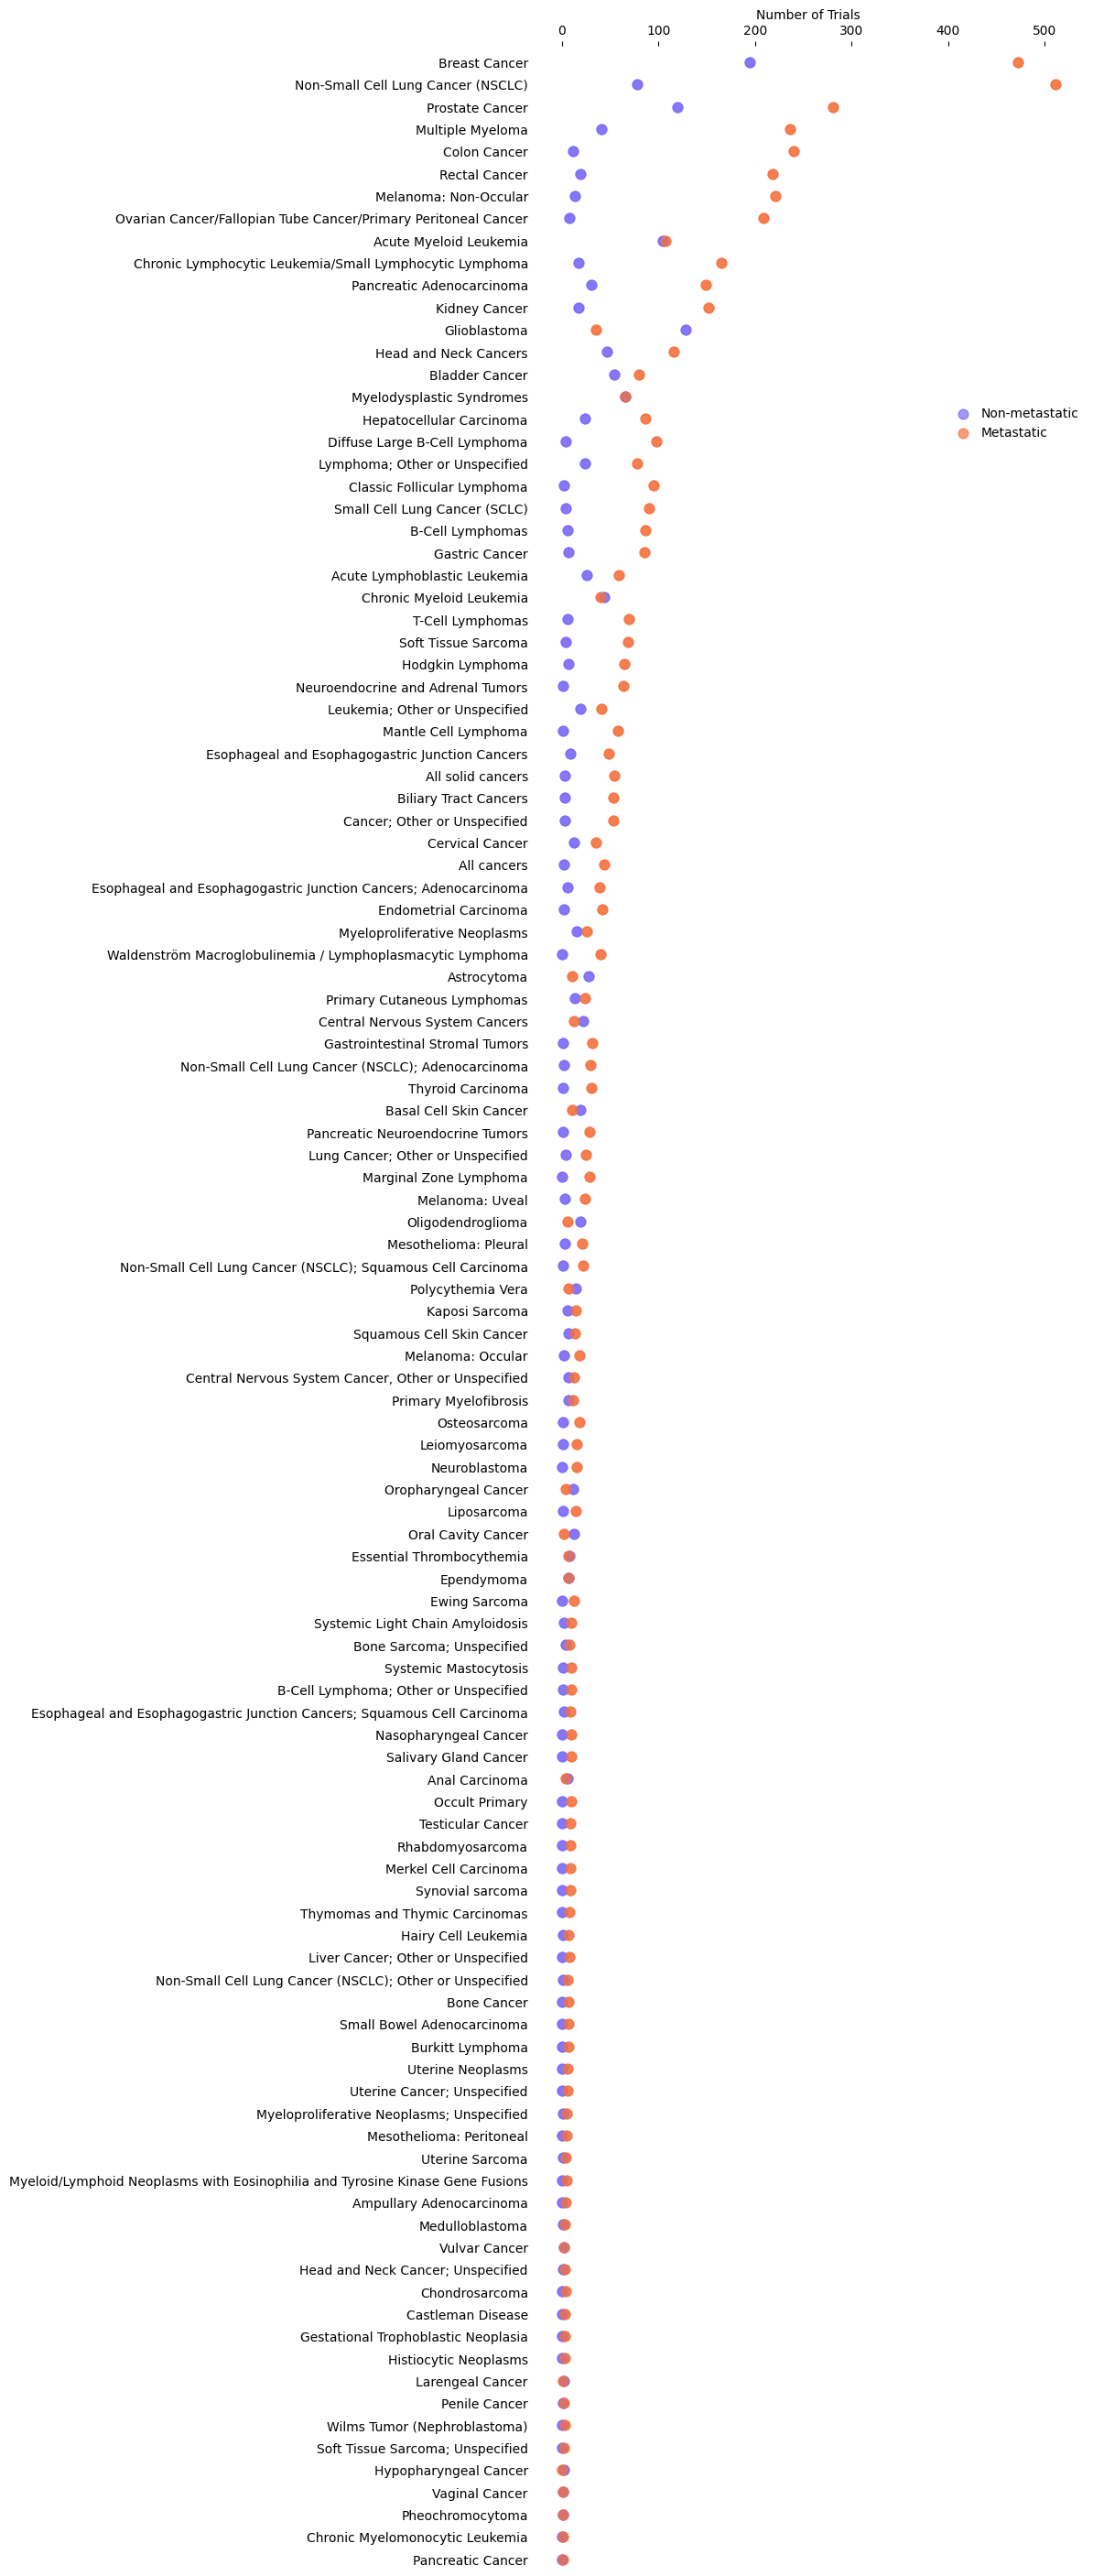

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cancer_col     = "ai_conditions"
trial_id_col   = "nct_id"
metastatic_col = "metastatic"

# remove trials not studying cancer; should have removed these above, but better later then never
def is_only_not_cancer(x):
    if isinstance(x, (list, np.ndarray)) and len(x) == 1:
        val = x[0]
        return isinstance(val, str) and val.strip().lower() == 'not cancer'
    return False

results = results[~results['ai_conditions'].apply(is_only_not_cancer)]


def to_label_list(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, (list, tuple, set, np.ndarray, pd.Series)):
        seq = x.tolist() if isinstance(x, (np.ndarray, pd.Series)) else list(x)
        return [str(v).strip() for v in seq if v is not None and str(v).strip()]
    s = str(x).strip()
    if not s:
        return []
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1].strip()
    return [t.strip() for t in s.split(",") if t.strip()]


# ---- One row per (trial, cancer_type, metastatic) ----
labels_long = (
    results[[trial_id_col, cancer_col, metastatic_col]]
    .assign(_labels=lambda d: d[cancer_col].apply(to_label_list))
    .explode("_labels")
    .dropna(subset=["_labels"])
    .rename(columns={"_labels": "cancer_type"})
    [[trial_id_col, "cancer_type", metastatic_col]]
    .drop_duplicates()
)

# ---- Count trials per cancer type & metastatic flag ----
counts_2d = (
    labels_long
    .groupby(["cancer_type", metastatic_col], as_index=False)
    .agg(trials=(trial_id_col, "nunique"))
    .pivot(index="cancer_type", columns=metastatic_col, values="trials")
    .fillna(0)
    .astype(int)
)

# ---- Order by total descending ----
counts_2d["total"] = counts_2d[False] + counts_2d[True]
counts_2d = counts_2d.sort_values("total", ascending=False)

# ---- Plot: two dots per cancer type (same y-level; equal values will overlap) ----
false_color = "#7b6af7"
true_color  = "#f57340"
alpha = 0.7
ms = 60

y = list(range(len(counts_2d)))
fig, ax = plt.subplots(figsize=(12, max(2, 0.25 * len(counts_2d))))

ax.set_yticks(y, counts_2d.index)
ax.scatter(counts_2d.get(False, 0).values, y, s=ms, color=false_color, alpha=alpha)
ax.scatter(counts_2d.get(True,  0).values, y, s=ms, color=true_color,  alpha=alpha)

# Move x-axis to the top
ax.set_xlabel("Number of Trials")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)

# Aesthetics
ax.set_ylim(-0.75, len(counts_2d) - 0.75)  # exact bounds for categories
ax.invert_yaxis()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False)

# Legend
nonmeta_scatter = ax.scatter(counts_2d[False].values, y, s=ms, color=false_color, alpha=alpha)
meta_scatter    = ax.scatter(counts_2d[True].values,  y, s=ms, color=true_color,  alpha=alpha)

leg = ax.legend(
    [nonmeta_scatter, meta_scatter],
    ["Non-metastatic", "Metastatic"],
    loc="center left",
    bbox_to_anchor=(0.75, 0.85),
    frameon=False,
    scatterpoints=1,
    handlelength=1.2,
    borderaxespad=0.5,
)

plt.tight_layout()
plt.show()



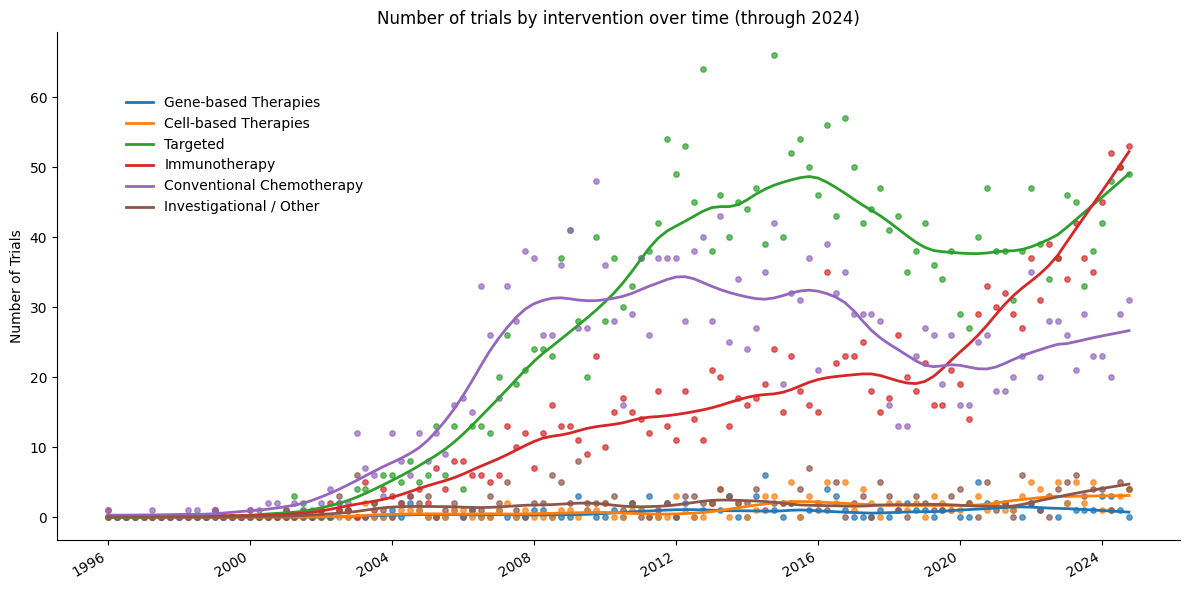

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

date_col = "completion_date"
intervention_cols = [
    "intervention_gene_therapies",
    "intervention_cell_based_therapies",
    "intervention_targeted",
    "intervention_immuno",
    "intervention_conventional",
    "intervention_investigational",
]
nice_names = {
    "intervention_gene_therapies": "Gene-based Therapies",
    "intervention_cell_based_therapies": "Cell-based Therapies",
    "intervention_targeted": "Targeted",
    "intervention_immuno": "Immunotherapy",
    "intervention_conventional": "Conventional Chemotherapy",
    "intervention_investigational": "Investigational / Other",
}

df = results.copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])
df[intervention_cols] = df[intervention_cols].fillna(0).astype(int)

# ---- Group by calendar quarter ----
df["qtr"] = df[date_col].dt.to_period("Q")

# ---- Truncate anything after 2024 as aggregates look wrong ----
end_cutoff = pd.Period("2024Q4")
df = df[(df["qtr"] <= end_cutoff)]

# ---- Aggregate per quarter ----
quarterly = (
    df.groupby("qtr", as_index=True)[intervention_cols]
      .sum()
      .rename(columns=nice_names)
)

full_idx = pd.period_range(quarterly.index.min(), end_cutoff, freq="Q")
quarterly = quarterly.reindex(full_idx, fill_value=0)

x = quarterly.index.to_timestamp(how="start")

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12, 6))
x_num = x.astype(np.int64)

for col in quarterly.columns:
    y = quarterly[col].values

    # LOWESS smoothing
    smoothed = lowess(y, x_num, frac=0.15)
    x_smooth = pd.to_datetime(smoothed[:, 0])
    y_smooth = smoothed[:, 1]
    ax.plot(x_smooth, y_smooth, linewidth=2, label=col)
    ax.scatter(x, y, s=15, alpha=0.7)


# Title and labels
ax.set_title("Number of trials by intervention over time (through 2024)", pad=6)
ax.set_ylabel("Number of Trials")

ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.05, 0.9), frameon=False)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


The above shows a dramatic increase in the number of trials from the late 1990s to early 2000s. In reality, there was an increase in the number of trials, but it wasn't nearly this dramatic. The graph reflects the fact that trials were [required to be registered](https://https://clinicaltrials.gov/policy/faq) if they were initiated after September 27, 2007 or were initiated on or before that date and was still ongoing as of December 26, 2007. As such, we'll further limit our sample to trials that completed in 2008 or later.

In [ ]:
trials_with_epi = results

trials_with_epi['start_date'] = pd.to_datetime(trials_with_epi['start_date'], errors='coerce')
trials_with_epi['completion_date'] = pd.to_datetime(trials_with_epi['completion_date'], errors='coerce')

trials_with_epi['start_year'] = trials_with_epi['start_date'].dt.year
trials_with_epi['completion_year'] = trials_with_epi['completion_date'].dt.year
trials_with_epi = trials_with_epi[trials_with_epi['completion_year'] >= 2008]


In [ ]:
# some light feature engineering outside the BigQuery queries
trials_with_epi['planned_length'] = trials_with_epi['completion_year']  - trials_with_epi['start_year']

# Phase: extract number and one-hot encode (some trials are "Phase 2/3")
trials_with_epi['phase_clean'] = trials_with_epi['phase'].str.extract(r'PHASE\s*(\d+)', expand=False)
trials_with_epi = pd.get_dummies(trials_with_epi, columns=['phase_clean'], prefix='phase')

# Randomization and blinding flags from trial title
trials_with_epi['is_randomized'] = trials_with_epi['official_title'].str.contains("randomized", case=False, na=False).astype(int)
trials_with_epi['is_blinded'] = trials_with_epi['official_title'].str.contains("blind", case=False, na=False).astype(int)

# Log of Enrollment as % of incidence:
trials_with_epi['enrollment_pct_incidence'] = (
    np.log1p(trials_with_epi['ai_planned_enrollment'] / trials_with_epi['total_incidence'])
).replace([np.inf, -np.inf], np.nan)

trials_with_epi['enrollment_pct_deaths'] = (
    np.log1p(trials_with_epi['ai_planned_enrollment'] / trials_with_epi['total_deaths'])
).replace([np.inf, -np.inf], np.nan)

trials_with_epi['planned_enrollment_per_year'] = trials_with_epi['ai_planned_enrollment'] / trials_with_epi['planned_length']

def has_leukemia_or_lymphoma(conds):
    if isinstance(conds, (list, np.ndarray)):
        return any(
            isinstance(c, str) and (
                'leukemia' in c.lower() or 'lymphoma' in c.lower()
            )
            for c in conds
        )
    return False

trials_with_epi['is_leukemia_or_lymphoma'] = trials_with_epi['ai_conditions'].apply(has_leukemia_or_lymphoma).astype(int)

# For each trial-condition, count competing trials that are still open
# Explode conditions to trial-condition rows
exploded = trials_with_epi.explode("ai_conditions")

def competition_count(sub):
    start = sub['start_date'].iloc[0]
    cond = sub['ai_conditions'].iloc[0]
    mask = (
        (exploded['ai_conditions'] == cond) &
        (exploded['start_date'] <= start) &   # trial started before or on this date
        (exploded['completion_date'] >= start)  # and has not finished yet
    )
    return mask.sum()

exploded['comp_count'] = (
    exploded.groupby(['nct_id','ai_conditions'])
    .apply(competition_count)
    .reset_index(level=[0,1], drop=True)
)

# Aggregate back to trial level
comp_scores = (
    exploded.groupby('nct_id')['comp_count'].sum().reset_index()
    .rename(columns={'comp_count': 'competition_score'})
)

trials_with_epi = trials_with_epi.merge(comp_scores, on='nct_id', how='left')



/tmp/ipython-input-1100558300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_with_epi['planned_length'] = trials_with_epi['completion_year']  - trials_with_epi['start_year']
/tmp/ipython-input-1100558300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_with_epi['phase_clean'] = trials_with_epi['phase'].str.extract(r'PHASE\s*(\d+)', expand=False)
/tmp/ipython-input-1100558300.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated,

### Defining the outcome measure
We'll define low accrual as trials that closed with substantially lower-than-planned enrollment and were therefore unlikely to generate sufficient evidence to address the primary endpoint. Following the same approach as I used in my dissertation, I'll classify trials as having low accrual if their actual accrual was less than 50% of what was planned. I also explored alternative thresholds (25% and 75%) in sensitivity analyses and the results were similar (it's slightly easier to predict the more extreme outcomes).

In [ ]:
trials_with_epi = trials_with_epi.dropna(subset=["enrollment", "ai_planned_enrollment"])

# Now create the target. I'll use a very similar definition as I used during my PhD, which is trials that enroll <50% of their target have "poor" accrual
# This outcome overalps highly with 'TERMINATED' outcome as most terminated trials experienced poor accrual, but some trials terminate early due to toxicity or safety concerns (not due to difficulty enrolling patients)

trials_with_epi['target'] = (
    (trials_with_epi['enrollment'] / trials_with_epi['ai_planned_enrollment'] < 0.5)
).astype(int)

pd.crosstab(trials_with_epi["overall_status"], trials_with_epi["target"])


target,0,1
overall_status,,
COMPLETED,2401,541
TERMINATED,626,1015


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

mlb = MultiLabelBinarizer()

temp = trials_with_epi.copy()
temp = temp[temp['completion_year'] >= 2007]

temp["conditions_str"] = temp["raw_conditions"].apply(lambda conds: " | ".join(conds))
X_conditions = mlb.fit_transform(temp["raw_conditions"])

X = temp[['is_leukemia_or_lymphoma', 'competition_score', 'planned_enrollment_per_year', 'planned_length', 'intervention_targeted', 'intervention_conventional', 'intervention_immuno', 'metastatic', 'phase_2', 'is_randomized', 'is_blinded', 'ai_complexity_score', 'ai_burden_score']]
y = temp['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Accuracy: 0.7862595419847328
ROC AUC: 0.8242134062927498

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       645
           1       0.66      0.58      0.62       272

    accuracy                           0.79       917
   macro avg       0.74      0.73      0.73       917
weighted avg       0.78      0.79      0.78       917



Overall the model achieves high accuracy with a strong AUC score, which indicates good discrimination between trials that will vs. won't experience low accrual. For context, my dissertation research reported an AUC of only 0.73 when predicting low accrual in NCTN trials. Other published efforts have reported AUCs in the 0.65 to 0.74 range.

https://www.sciencedirect.com/science/article/pii/S2451865419300304

https://pmc.ncbi.nlm.nih.gov/articles/PMC6658414/

https://pubmed.ncbi.nlm.nih.gov/29859791/

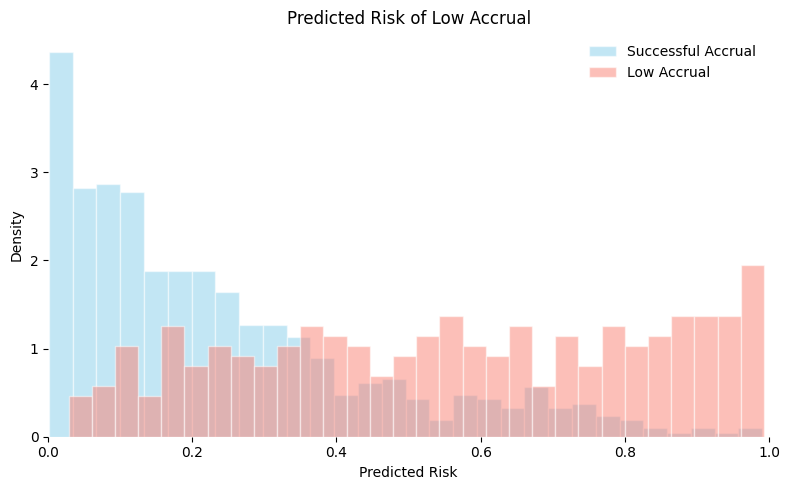

In [ ]:

df = pd.DataFrame({
    'y_true': y_test,
    'y_prob': y_prob
})

pos = df[df['y_true'] == 1]['y_prob']  # Low accrual
neg = df[df['y_true'] == 0]['y_prob']  # Successful accrual

plt.figure(figsize=(8, 5))
plt.hist(neg, bins=30, alpha=0.5, label='Successful Accrual', color='skyblue', edgecolor='white', density=True)
plt.hist(pos, bins=30, alpha=0.5, label='Low Accrual', color='salmon', edgecolor='white', density=True)

for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.title('Predicted Risk of Low Accrual')
plt.xlabel('Predicted Risk')
plt.ylabel('Density')
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

Other features that could be interesting to look at if I had more time:

- BERT / embedding similarity between trial descriptions → cluster by novelty or redundancy.
- Trial density per condition per year
- Overlap in enrollment windows → how many trials with the same condition are recruiting at the same time.
- Novelty of intervention → count how many trials have already tested the same drug class / target.
- First-in-class vs me-too → whether drug is first in its target or similar to others.
- Overlap of conditions → # of conditions per trial (multi-disease trials harder to recruit).
- Sponsor experience → # of prior trials run by sponsor in this condition or overall.

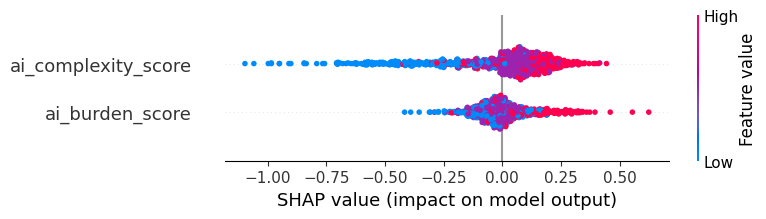

In [ ]:
# we can also peek at how important the features that we might be able to change are:
import shap

X_test_clean = X_test.fillna(0)
explainer = shap.Explainer(clf)
shap_values = explainer(X_test_clean)

features_to_plot = ["ai_complexity_score", "ai_burden_score"]

shap.summary_plot(
    shap_values[:, features_to_plot],
    X_test_clean[features_to_plot]
)

# these show the relationship I hypothesized: higher complexity and burden is associated with higher risk of low accrual.

# Project #2: Helping Patients Find Eligible Clinical Trials

Finding a clinical trial as a patient is notoriously difficult. The primary tool available today, ClinicalTrials.gov, allows only very broad keyword searches (e.g., “breast cancer”) and then returns thousands of results. From there, patients (and often even their clinicians) must wade through dense and highly technical trial records to determine eligibility. Critical details like inclusion/exclusion criteria, prior lines of therapy, biomarker requirements, and trial phase are buried in unstructured free-text fields. This complexity [creates a huge barrier for patients to find and ultimately enroll in trials they may be eligible for](https://https://www.statnews.com/2020/04/28/make-clinicaltrials-gov-a-better-tool-for-patients/).

My aim is to build a better tool that leverages BigQuery's AI capabilities to make trial search more intuitive and precise. Instead of relying on rigid categorical filters, we can encode both trial records and patient profiles as embeddings and measure similarity directly. A patient (or their provider) could enter information in natural language (e.g., “Stage IV metastatic melanoma after progression on anti-PD1”) and the system would return trials where the eligibility criteria match that clinical context, not just the broad label “melanoma.”

This approach has several advantages. It handles the nuance and variability in how trial eligibility is written, captures relationships across related concepts (e.g., “non-small cell lung cancer” vs. “NSCLC”), and makes it possible to surface trials that patients might otherwise overlook. It also relieves patients from having to parse complex medical jargon, since the model learns embeddings from the raw text. The result is a more equitable and accessible entry point into clinical research.

Whereas the prior project focused on modeling accrual risk to optimize trial design, this project focuses on empowering patients directly: reducing search friction, improving awareness of open studies, and ultimately helping more patients access innovative therapies. By reframing trial search as a modern information retrieval problem, we can dramatically improve on today's broken tools and move toward a more patient-centric ecosystem.

In [ ]:
# we'll use the same sample of trials from AACT, but limit to those that are still open for enrolllment
recruiting_trials = df[df['overall_status'] == 'RECRUITING']
len(recruiting_trials) # a reasonable number for this prototype (represents about 10% of all trials available)

2807

In [ ]:
# create concatenated text of the title, description, eligibility criteria and conditions being studied (we can just use the raw values here as we'll embed everything)
recruiting_trials['full_text'] = str(recruiting_trials['official_title']) + str(recruiting_trials['description']) + str(recruiting_trials['eligibility']) + str(recruiting_trials['raw_conditions'])

/tmp/ipython-input-591896839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruiting_trials['full_text'] = str(recruiting_trials['official_title']) + str(recruiting_trials['description']) + str(recruiting_trials['eligibility']) + str(recruiting_trials['raw_conditions'])


In [ ]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL `kaggle-clinical-trials.aact.text_embedding_model`
  REMOTE WITH CONNECTION `us.kaggle_connection`
  OPTIONS (ENDPOINT = 'gemini-embedding-001');

Query is running:   0%|          |

""


In [ ]:
# save out this dataset to BigQuery
bq_client = bigquery.Client(project=PROJECT_ID)
dataset_id = "aact"
table_id = f"{PROJECT_ID}.{dataset_id}.open_trials"

bq_client.create_dataset(dataset_id, exists_ok=True)
job = bq_client.load_table_from_dataframe(recruiting_trials, table_id)
job.result()

print(f"Uploaded {len(recruiting_trials)} rows to {table_id}")

Uploaded 2807 rows to kaggle-clinical-trials.aact.open_trials


In [ ]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE TABLE `kaggle-clinical-trials.aact.trial_embeddings` AS
SELECT
  nct_id,
  ml_generate_embedding_result     AS embedding,
  ml_generate_embedding_statistics AS stats,
  ml_generate_embedding_status     AS status
FROM ML.GENERATE_EMBEDDING(
  MODEL `kaggle-clinical-trials.aact.text_embedding_model`,
  (
    SELECT
      nct_id,
      CAST(description AS STRING) AS content
    FROM `kaggle-clinical-trials.aact.open_trials`
  )
)


Query is running:   0%|          |

""


Peek at just using embeddings. In general this returns "relevant" trials, but it's not a great system for determining whether a patient is truly eligible or not.

In [ ]:
%%bigquery --project {PROJECT_ID}

SELECT *
    FROM
      VECTOR_SEARCH(
        TABLE `kaggle-clinical-trials.aact.trial_embeddings`,
        'embedding',
        (
        SELECT
          ml_generate_embedding_result,
          content AS query
        FROM
          ML.GENERATE_EMBEDDING(
            MODEL `kaggle-clinical-trials.aact.text_embedding_model`,
            ( SELECT "stage III HR+ breast cancer" AS content)
          )
        ),
        top_k => 3)
ORDER BY distance ASC;


Query is running:   0%|          |

Downloading:   0%|          |

,query,base,distance
0,{'ml_generate_embedding_result': [0.0063416124...,"{'nct_id': 'NCT05501886', 'embedding': [-0.001...",0.745686
1,{'ml_generate_embedding_result': [0.0063416124...,"{'nct_id': 'NCT06507618', 'embedding': [-0.002...",0.746299
2,{'ml_generate_embedding_result': [0.0063416124...,"{'nct_id': 'NCT05826964', 'embedding': [0.0116...",0.749933


Let's use embeddings to return relevant trials, then an LLM to determine eligibility. We'll need to use gemini-2.5-pro here as the task is complex - the model needs to be able to understand nuance like 'early stage breast cancer' includes Stage IIIA (but not stage IIIB or IIIC, which are considered advanced).

In [ ]:
%%bigquery eligible_trials --project {PROJECT_ID}

WITH top_trials AS (
  SELECT DISTINCT
    base.nct_id AS nct_id,
    distance
  FROM VECTOR_SEARCH(
    TABLE `kaggle-clinical-trials.aact.trial_embeddings`,
    'embedding',
    (
      SELECT
        ml_generate_embedding_result,
        content AS query
      FROM ML.GENERATE_EMBEDDING(
        MODEL `kaggle-clinical-trials.aact.text_embedding_model`,
        ( SELECT "metastatic HR+ breast cancer" AS content )
      )
    ),
    top_k => 10
  )
),
eligibility AS (
  SELECT
    t.nct_id,
    t.official_title,
    t.eligibility,
    d.distance,
    AI.GENERATE_BOOL(
      (
        'Is this patient potentially currently eligible for the trial, based on the eligibility criteria? Carefully consider the condition, stage of the cancer, prior treatment history and other conditions (if provided).',
        'Only evaluate for the trials the patient is eligible now. Do not consider trials in which the patient may be eligible in the future (e.g., after they progress to metastatic disease).'
        'Answer only True or False.',
        'Patient profile: metastatic HR+ breast cancer',
        '\n\nTITLE: ', t.official_title,
        '\nELIGIBILITY CRITERIA: ', t.eligibility
      ),
      connection_id => 'us.kaggle_connection',
      endpoint      => 'gemini-2.5-pro'
    ) AS eligible
  FROM top_trials d
  JOIN `kaggle-clinical-trials.aact.open_trials` t
    ON d.nct_id = t.nct_id
)
SELECT *
FROM eligibility
WHERE eligible.result = TRUE
ORDER BY distance ASC
LIMIT 5;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
eligible_trials

,nct_id,official_title,eligibility,distance,eligible
0,NCT05826964,Levels of Circulating Tumor DNA as a Predictiv...,[Inclusion Criteria:\n\n1. Men or women age ≥ ...,0.696268,"{'result': True, 'full_response': '{""candidate..."
1,NCT04563507,CIMER: Combined Immunotherapies in Metastatic ...,[Newly diagnosed advanced/metastatic breast ca...,0.710643,"{'result': True, 'full_response': '{""candidate..."


In [ ]:
%%bigquery eligible_trials --project {PROJECT_ID}

WITH top_trials AS (
  SELECT DISTINCT
    base.nct_id AS nct_id,
    distance
  FROM VECTOR_SEARCH(
    TABLE `kaggle-clinical-trials.aact.trial_embeddings`,
    'embedding',
    (
      SELECT
        ml_generate_embedding_result,
        content AS query
      FROM ML.GENERATE_EMBEDDING(
        MODEL `kaggle-clinical-trials.aact.text_embedding_model`,
        ( SELECT "metastatic EGFR+ NSCLC previously treated with targeted therapy" AS content )
      )
    ),
    top_k => 10
  )
),
eligibility AS (
  SELECT
    t.nct_id,
    t.official_title,
    t.eligibility,
    d.distance,
    AI.GENERATE_BOOL(
      (
        'Is this patient potentially currently eligible for the trial, based on the eligibility criteria? Carefully consider the condition, stage of the cancer, prior treatment history and other conditions (if provided).',
        'Only evaluate for the trials the patient is eligible now. Do not consider trials in which the patient may be eligible in the future (e.g., after they progress to metastatic disease).'
        'Answer only True or False.',
        'Patient profile: metastatic EGFR+ NSCLC previously treated with targeted therapy',
        '\n\nTITLE: ', t.official_title,
        '\nELIGIBILITY CRITERIA: ', t.eligibility
      ),
      connection_id => 'us.kaggle_connection',
      endpoint      => 'gemini-2.5-pro'
    ) AS eligible
  FROM top_trials d
  JOIN `kaggle-clinical-trials.aact.open_trials` t
    ON d.nct_id = t.nct_id
)
SELECT *
FROM eligibility
WHERE eligible.result = TRUE
ORDER BY distance ASC
LIMIT 2;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
eligible_trials

,nct_id,official_title,eligibility,distance,eligible
0,NCT06305754,"A Randomized, Open-label, Phase 3 Study of MK-...",[Inclusion Criteria:\n\n* Histologically or cy...,0.755962,"{'result': True, 'full_response': '{""candidate..."
1,NCT04958811,A Phase II Open-label Multi-cohort Study Evalu...,[Inclusion Criteria:\n\n* Signed Informed Cons...,0.768969,"{'result': True, 'full_response': '{""candidate..."


And to drive home how impressive this search strategy is compared to what is available now for patients, let's compare with clinicaltrials.gov. If we were to search for the same terms "metastatic EGFR+ NSCLC previously treated with targeted therapy", we'd return the trials [listed here](https://https://clinicaltrials.gov/search?term=metastatic%20EGFR%2B%20NSCLC%20previously%20treated%20with%20targeted%20therapy&aggFilters=phase:2%203,status:rec). Note that neither of the correctly identified trials listed above are included in this list and none of 6 trials returned from clinicaltrials.gov are truly relevant (the list includes a few trials in NSCLC, but for patients who don't have EGFR mutations, or have not yet received treatment; neither of which would fit the patient's profile we've entered).  